In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, linregress
import seaborn as sns

circles = pd.read_csv("../data/circles.csv")
duplex = pd.read_csv("../data/duplex.csv")
shared = pd.read_csv("../data/shared.csv")
russell = pd.read_csv("../data/russell_2020_vars.csv")

In [ ]:
def plot_af_correlation(shared_df, figsize=(6, 6)):
    """Plot allele frequency correlation with marginal histograms."""

    sns.set_theme(style="ticks")

    circles_freq = shared_df["circles_freq_raw"].to_numpy()
    duplex_freq = shared_df["duplex_freq_raw"].to_numpy()
    r, p = pearsonr(circles_freq, duplex_freq)

    g = sns.jointplot(
        x=np.log10(circles_freq),
        y=np.log10(duplex_freq),
        kind="scatter",
        height=figsize[0],
        ratio=5,
        joint_kws=dict(alpha=0.6, s=50, color="black", edgecolors="none"),
        marginal_kws=dict(bins=10, color="lightgray", edgecolor="black", linewidth=0.5),
    )

    g.ax_joint.set_xlim(-3.1, -1.5)
    g.ax_joint.set_ylim(-3.1, -1.5)
    g.ax_joint.plot([-3.1, -1.5], [-3.1, -1.5], "k--", linewidth=1.5, alpha=0.5)

    ticks = [-3, -2.5, -2, -1.5]
    tick_labels = ["$10^{-3}$", "", "$10^{-2}$", ""]
    g.ax_joint.set_xticks(ticks)
    g.ax_joint.set_xticklabels(tick_labels)
    g.ax_joint.set_yticks(ticks)
    g.ax_joint.set_yticklabels(tick_labels)

    g.ax_joint.set_xlabel("CircleSeq Allele Frequency", fontsize=12)
    g.ax_joint.set_ylabel("IndexSeq Allele Frequency", fontsize=12)
    g.ax_joint.text(
        0.05,
        0.95,
        f"$r$ = {r:.2f}, $p$ = {p:.3f}",
        transform=g.ax_joint.transAxes,
        va="top",
        ha="left",
        fontsize=10,
    )

    print(f"Allele Frequency Correlation:")
    print(f"  Pearson r = {r:.4f} (p = {p:.3e})")
    print(f"  n = {len(circles_freq)}")

    return g.figure

Allele Frequency Correlation:
  Pearson r = 0.6152 (p = 3.886e-03)
  n = 20


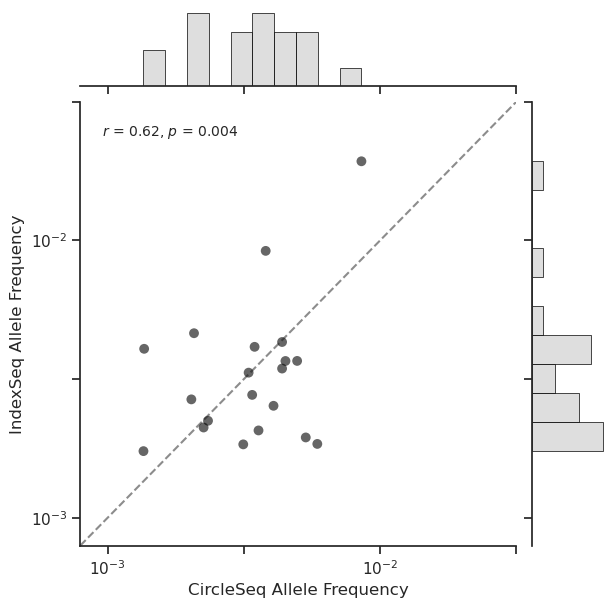

In [100]:
fig = plot_af_correlation(shared)

In [ ]:
from scipy.stats import hypergeom


def test_overlap_hypergeometric(
    circles: pd.DataFrame,
    duplex: pd.DataFrame,
    genome_size: int = 1_200_000,
) -> dict:
    """
    Test whether variant overlap exceeds chance using hypergeometric distribution.
    """
    c_keys = set(zip(circles["pos"], circles["ref"], circles["alt"]))
    d_keys = set(zip(duplex["pos"], duplex["ref"], duplex["alt"]))

    observed_overlap = len(c_keys & d_keys)
    n_circles = len(c_keys)
    n_duplex = len(d_keys)

    # Expected and variance
    expected = (n_circles * n_duplex) / genome_size
    var = (
        n_duplex
        * (n_circles / genome_size)
        * (1 - n_circles / genome_size)
        * ((genome_size - n_duplex) / (genome_size - 1))
    )

    # P(X >= observed)
    p_value = hypergeom.sf(observed_overlap - 1, genome_size, n_circles, n_duplex)

    return {
        "observed_overlap": observed_overlap,
        "expected_overlap": expected,
        "std_overlap": np.sqrt(var),
        "fold_enrichment": observed_overlap / expected,
        "p_value": p_value,
        "z_score": (observed_overlap - expected) / np.sqrt(var),
        "n_circles": n_circles,
        "n_duplex": n_duplex,
        "genome_size": genome_size,
    }


results = test_overlap_hypergeometric(circles, duplex)
results

{'observed_overlap': 48,
 'expected_overlap': 23.22289333333333,
 'std_overlap': np.float64(4.797402623373405),
 'fold_enrichment': 2.0669259127630952,
 'p_value': np.float64(4.032235950735221e-06),
 'z_score': np.float64(5.164691940999538),
 'n_circles': 6427,
 'n_duplex': 4336,
 'genome_size': 1200000}

In [ ]:
TRANSITIONS = {("A", "G"), ("G", "A"), ("C", "T"), ("T", "C")}


def classify_mutation(ref: str, alt: str) -> str:
    """Classify a mutation as transition (Ti) or transversion (Tv)."""
    if (ref, alt) in TRANSITIONS:
        return "Ti"
    return "Tv"


def calc_titv_ratio(df: pd.DataFrame) -> dict:
    """
    Calculate transition/transversion ratio for a variant dataframe.

    """

    counts = df["mutation_type"].value_counts()
    n_ti = counts.get("Ti", 0)
    n_tv = counts.get("Tv", 0)

    ratio = n_ti / n_tv if n_tv > 0 else float("inf")

    return {
        "n_ti": n_ti,
        "n_tv": n_tv,
        "titv_ratio": ratio,
    }


def plot_titv_comparison(shared, circles_filt, duplex_filt, russell, figsize=(8, 4)):
    """Ti/Tv ratios with chi-square tests vs Russell et al."""

    sns.set_theme(style="ticks")
    from scipy.stats import chi2_contingency

    shared_keys = set(zip(shared["pos"], shared["ref"], shared["alt"]))
    circles_unique = circles_filt[
        ~circles_filt.apply(
            lambda r: (r["pos"], r["ref"], r["alt"]) in shared_keys, axis=1
        )
    ]
    duplex_unique = duplex_filt[
        ~duplex_filt.apply(
            lambda r: (r["pos"], r["ref"], r["alt"]) in shared_keys, axis=1
        )
    ]

    datasets = {
        "Shared": shared,
        "Russell\net al.": russell,
        "CircleSeq\n(unique)": circles_unique,
        "IndexSeq\n(unique)": duplex_unique,
    }

    titvs = {}
    for name, df in datasets.items():
        counts = df["mutation_type"].value_counts()
        n_ti, n_tv = counts.get("Ti", 0), counts.get("Tv", 0)
        titvs[name] = {
            "n_ti": n_ti,
            "n_tv": n_tv,
            "ratio": n_ti / n_tv if n_tv > 0 else float("inf"),
        }

    def chi2_test(a, b):
        table = [[a["n_ti"], a["n_tv"]], [b["n_ti"], b["n_tv"]]]
        chi2, p, _, _ = chi2_contingency(table)
        return chi2, p

    russell_key = "Russell\net al."
    comparisons = {}
    for name in ["Shared", "CircleSeq\n(unique)", "IndexSeq\n(unique)"]:
        chi2, p = chi2_test(titvs[name], titvs[russell_key])
        comparisons[name] = {"chi2": chi2, "p": p}

    # build dataframe for seaborn
    categories = list(datasets.keys())
    ratios = [titvs[c]["ratio"] for c in categories]
    n_variants = [titvs[c]["n_ti"] + titvs[c]["n_tv"] for c in categories]
    colors = ["#5B8C5A", "#7A7A7A", "#4A90A4", "#D4815E"]

    fig, ax = plt.subplots(figsize=figsize)
    bars = ax.bar(categories, ratios, color=colors, edgecolor="black", linewidth=0.8)

    for bar, ratio, n in zip(bars, ratios, n_variants):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.02,
            f"{ratio:.2f}\n(n={n:,})",
            ha="center",
            va="bottom",
            fontsize=9,
        )

    ax.set_ylim(0, max(ratios) * 1.5)
    ax.set_ylabel("Ti/Tv Ratio", fontsize=12)

    def sig_label(p):
        if p < 0.001:
            return "***"
        elif p < 0.01:
            return "**"
        elif p < 0.05:
            return "*"
        return "ns"

    bar_y = max(ratios) * 1.02
    step = max(ratios) * 0.12
    for i, (comp_idx, name) in enumerate(
        [(2, "CircleSeq\n(unique)"), (3, "IndexSeq\n(unique)"), (0, "Shared")]
    ):
        x1 = bars[1].get_x() + bars[1].get_width() / 2
        x2 = bars[comp_idx].get_x() + bars[comp_idx].get_width() / 2
        y = bar_y + i * step
        tip = step * 0.2
        ax.plot([x1, x1, x2, x2], [y - tip, y, y, y - tip], color="black", linewidth=1)
        ax.text(
            (x1 + x2) / 2,
            y + 0.01,
            sig_label(comparisons[name]["p"]),
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

    sns.despine(ax=ax)
    fig.tight_layout()

    for name, s in titvs.items():
        print(f"{name}: Ti/Tv = {s['ratio']:.2f} ({s['n_ti']} Ti, {s['n_tv']} Tv)")
        if name in comparisons:
            print(
                f"  vs Russell: χ² = {comparisons[name]['chi2']:.2f}, p = {comparisons[name]['p']:.2e}"
            )

    return fig

Shared: Ti/Tv = 3.00 (15 Ti, 5 Tv)
  vs Russell: χ² = 0.05, p = 8.22e-01
Russell
et al.: Ti/Tv = 2.35 (589 Ti, 251 Tv)
CircleSeq
(unique): Ti/Tv = 0.64 (2497 Ti, 3910 Tv)
  vs Russell: χ² = 293.38, p = 9.14e-66
IndexSeq
(unique): Ti/Tv = 0.56 (1558 Ti, 2758 Tv)
  vs Russell: χ² = 333.50, p = 1.66e-74


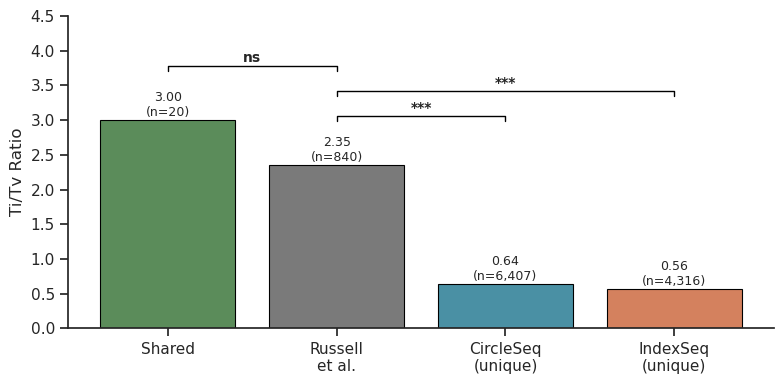

In [104]:
circles["mutation_type"] = circles.apply(
    lambda r: classify_mutation(r["ref"], r["alt"]), axis=1
)
duplex["mutation_type"] = duplex.apply(
    lambda r: classify_mutation(r["ref"], r["alt"]), axis=1
)
fig = plot_titv_comparison(shared, circles, duplex, russell)

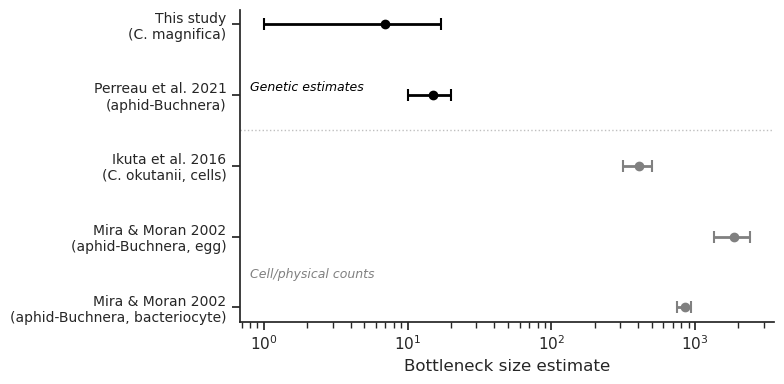

In [ ]:
def plot_bottleneck_forest(emp_mean, emp_lower, emp_upper, figsize=(8, 4)):
    """Forest plot comparing bottleneck estimates across studies."""

    sns.set_theme(style="ticks")

    studies = [
        ("This study\n(C. magnifica)", emp_mean, emp_lower, emp_upper, "genetic"),
        ("Perreau et al. 2021\n(aphid-Buchnera)", 15, 10, 20, "genetic"),
        ("Ikuta et al. 2016\n(C. okutanii, cells)", 408, 313, 503, "physical"),
        ("Mira & Moran 2002\n(aphid-Buchnera, egg)", 1872, 1348, 2396, "physical"),
        (
            "Mira & Moran 2002\n(aphid-Buchnera, bacteriocyte)",
            844,
            748,
            940,
            "physical",
        ),
    ]

    colors = {"genetic": "black", "physical": "gray"}

    fig, ax = plt.subplots(figsize=figsize)

    for y, (label, mean, lower, upper, cat) in enumerate(studies):
        ax.errorbar(
            mean,
            y,
            xerr=[[mean - lower], [upper - mean]],
            fmt="o",
            markersize=6,
            color=colors[cat],
            elinewidth=2,
            capsize=4,
            capthick=1.5,
            zorder=3,
        )

    ax.set_yticks(range(len(studies)))
    ax.set_yticklabels([s[0] for s in studies], fontsize=10)
    ax.set_xscale("log")
    ax.set_xlabel("Bottleneck size estimate", fontsize=12)

    # tick labels as 10^n
    import matplotlib.ticker as mticker

    ax.xaxis.set_major_formatter(
        mticker.FuncFormatter(
            lambda x, _: (
                f"$10^{{{int(np.log10(x))}}}$" if x in [1, 10, 100, 1000, 10000] else ""
            )
        )
    )

    ax.axhline(1.5, color="gray", linestyle=":", linewidth=1, alpha=0.5)

    ax.text(
        0.02,
        0.75,
        "Genetic estimates",
        transform=ax.transAxes,
        fontsize=9,
        fontstyle="italic",
        color="black",
        va="center",
        ha="left",
    )
    ax.text(
        0.02,
        0.15,
        "Cell/physical counts",
        transform=ax.transAxes,
        fontsize=9,
        fontstyle="italic",
        color="gray",
        va="center",
        ha="left",
    )

    ax.invert_yaxis()
    sns.despine(ax=ax)
    fig.tight_layout()

    return fig


fig = plot_bottleneck_forest(emp_mean=7, emp_lower=1, emp_upper=17)

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from pathlib import Path
import seaborn as sns

MODEL_DIR = Path("../results/model_output")
test_df = pd.read_csv(MODEL_DIR / "test_predictions.csv")
metadata = pd.read_csv(MODEL_DIR / "metadata.csv")

# back-transform from log10 at load time
config = pd.read_csv(MODEL_DIR / "config.csv")
if config["log_target"].item():
    test_df["y_true"] = 10 ** test_df["y_true"]
    test_df["y_pred"] = 10 ** test_df["y_pred"]

In [ ]:
def plot_predicted_vs_true(test_df, figsize=(6, 6)):
    """Predicted vs true Nb on held-out test set."""

    y_true = test_df["y_true"].to_numpy()
    y_pred = test_df["y_pred"].to_numpy()

    r, p = pearsonr(np.log10(y_true), np.log10(y_pred))
    rmse = np.sqrt(np.mean((np.log10(y_true) - np.log10(y_pred)) ** 2))

    g = sns.jointplot(
        x=np.log10(y_true),
        y=np.log10(y_pred),
        kind="scatter",
        height=figsize[0],
        ratio=5,
        joint_kws=dict(alpha=0.1, color="black", edgecolors="none"),
        marginal_kws=dict(bins=30, color="lightgray", edgecolor="black", linewidth=0.5),
        marginal_ticks=True,
    )

    g.ax_joint.plot([-0.2, 3.2], [-0.2, 3.2], "k--", linewidth=1.5, alpha=0.5)
    g.ax_joint.set_xlim(-0.2, 3.2)
    g.ax_joint.set_ylim(-0.2, 3.2)
    g.ax_joint.set_xlabel("True $N_b$", fontsize=12)
    g.ax_joint.set_ylabel("Predicted $N_b$", fontsize=12)

    # tick labels as 10^0, 10^1, etc.
    ticks = [0, 1, 2, 3]
    tick_labels = ["$10^0$", "$10^1$", "$10^2$", "$10^3$"]
    g.ax_joint.set_xticks(ticks)
    g.ax_joint.set_xticklabels(tick_labels)
    g.ax_joint.set_yticks(ticks)
    g.ax_joint.set_yticklabels(tick_labels)

    return g.figure

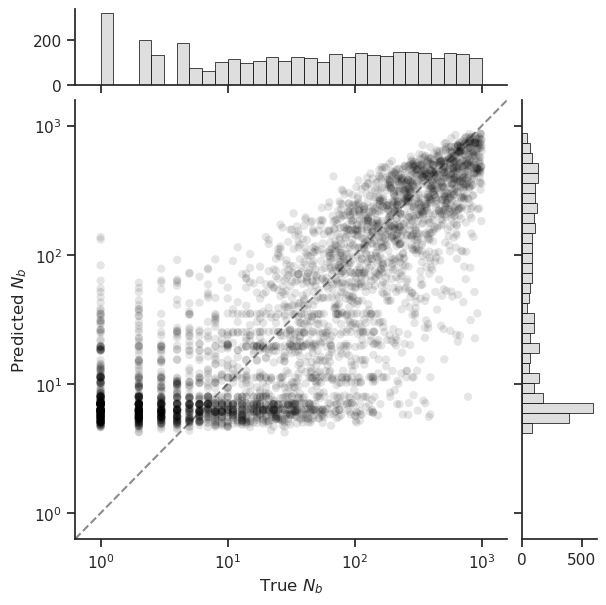

In [164]:
fig_a = plot_predicted_vs_true(test_df)


In [ ]:
def make_figure2(
    shared_df,
    circles_filt,
    duplex_filt,
    russell,
    test_df,
    emp_mean=7,
    emp_lower=1,
    emp_upper=17,
    figsize=(14, 12),
):
    """
    Figure 2: All results.
    Row 1: A) AF correlation  B) Ti/Tv  C) Forest plot
    Row 2: D) Predicted vs true  E-G) Nuisance residuals
    """

    sns.set_theme(style="ticks")
    from scipy.stats import chi2_contingency
    import matplotlib.ticker as mticker
    import matplotlib.gridspec as gridspec

    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(
        2,
        4,
        hspace=0.4,
        wspace=0.4,
        height_ratios=[1, 1],
        width_ratios=[1, 0.8, 0.8, 0.8],
    )

    # ---- A: AF correlation ----
    ax_a = fig.add_subplot(gs[0, 0])

    circles_freq = shared_df["circles_freq_raw"].to_numpy()
    duplex_freq = shared_df["duplex_freq_raw"].to_numpy()
    r_af, p_af = pearsonr(circles_freq, duplex_freq)

    ax_a.scatter(
        np.log10(circles_freq),
        np.log10(duplex_freq),
        alpha=0.6,
        s=50,
        color="black",
        edgecolors="none",
    )
    ax_a.plot([-3.1, -1.5], [-3.1, -1.5], "k--", linewidth=1.5, alpha=0.5)
    ax_a.set_xlim(-3.1, -1.5)
    ax_a.set_ylim(-3.1, -1.5)
    ax_a.set_aspect("equal")

    ticks_af = [-3, -2.5, -2, -1.5]
    tick_labels_af = ["$10^{-3}$", "", "$10^{-2}$", ""]
    ax_a.set_xticks(ticks_af)
    ax_a.set_xticklabels(tick_labels_af)
    ax_a.set_yticks(ticks_af)
    ax_a.set_yticklabels(tick_labels_af)
    ax_a.set_xlabel("CircleSeq Allele Frequency", fontsize=10)
    ax_a.set_ylabel("IndexSeq Allele Frequency", fontsize=10)
    ax_a.text(
        0.05,
        0.95,
        f"$r$ = {r_af:.2f}, $p$ = {p_af:.3f}",
        transform=ax_a.transAxes,
        va="top",
        ha="left",
        fontsize=9,
    )

    # ---- B: Ti/Tv (narrow bars) ----
    ax_b = fig.add_subplot(gs[0, 1])

    TRANSITIONS = {("A", "G"), ("G", "A"), ("C", "T"), ("T", "C")}
    for df in [shared_df, circles_filt, duplex_filt, russell]:
        if "mutation_type" not in df.columns:
            df["mutation_type"] = df.apply(
                lambda r: "Ti" if (r["ref"], r["alt"]) in TRANSITIONS else "Tv", axis=1
            )

    shared_keys = set(zip(shared_df["pos"], shared_df["ref"], shared_df["alt"]))
    circles_unique = circles_filt[
        ~circles_filt.apply(
            lambda r: (r["pos"], r["ref"], r["alt"]) in shared_keys, axis=1
        )
    ]
    duplex_unique = duplex_filt[
        ~duplex_filt.apply(
            lambda r: (r["pos"], r["ref"], r["alt"]) in shared_keys, axis=1
        )
    ]

    datasets = {
        "Shared": shared_df,
        "Russell\net al.": russell,
        "CircleSeq\n(unique)": circles_unique,
        "IndexSeq\n(unique)": duplex_unique,
    }
    colors_titv = ["#5B8C5A", "#7A7A7A", "#4A90A4", "#D4815E"]

    titvs = {}
    for name, df in datasets.items():
        counts = df["mutation_type"].value_counts()
        n_ti, n_tv = counts.get("Ti", 0), counts.get("Tv", 0)
        titvs[name] = {
            "n_ti": n_ti,
            "n_tv": n_tv,
            "ratio": n_ti / n_tv if n_tv > 0 else float("inf"),
        }

    categories = list(datasets.keys())
    ratios = [titvs[c]["ratio"] for c in categories]
    n_variants = [titvs[c]["n_ti"] + titvs[c]["n_tv"] for c in categories]

    x_pos = np.arange(len(categories))
    bar_width = 0.5
    bars = ax_b.bar(
        x_pos,
        ratios,
        width=bar_width,
        color=colors_titv,
        edgecolor="black",
        linewidth=0.8,
    )
    ax_b.set_xticks(x_pos)
    ax_b.set_xticklabels(categories, fontsize=7)

    for bar, ratio, n in zip(bars, ratios, n_variants):
        ax_b.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.02,
            f"{ratio:.2f}\n(n={n:,})",
            ha="center",
            va="bottom",
            fontsize=7,
        )

    ax_b.set_ylim(0, max(ratios) * 1.5)
    ax_b.set_ylabel("Ti/Tv Ratio", fontsize=10)

    russell_key = "Russell\net al."
    comparisons = {}
    for name in ["Shared", "CircleSeq\n(unique)", "IndexSeq\n(unique)"]:
        table = [
            [titvs[name]["n_ti"], titvs[name]["n_tv"]],
            [titvs[russell_key]["n_ti"], titvs[russell_key]["n_tv"]],
        ]
        chi2, p, _, _ = chi2_contingency(table)
        comparisons[name] = p

    def sig_label(p):
        if p < 0.001:
            return "***"
        elif p < 0.01:
            return "**"
        elif p < 0.05:
            return "*"
        return "ns"

    bar_y = max(ratios) * 1.02
    step = max(ratios) * 0.12
    for i, (comp_idx, name) in enumerate(
        [(2, "CircleSeq\n(unique)"), (3, "IndexSeq\n(unique)"), (0, "Shared")]
    ):
        x1 = bars[1].get_x() + bars[1].get_width() / 2
        x2 = bars[comp_idx].get_x() + bars[comp_idx].get_width() / 2
        y = bar_y + i * step
        tip = step * 0.2
        ax_b.plot(
            [x1, x1, x2, x2], [y - tip, y, y, y - tip], color="black", linewidth=0.8
        )
        ax_b.text(
            (x1 + x2) / 2,
            y + 0.01,
            sig_label(comparisons[name]),
            ha="center",
            va="bottom",
            fontsize=8,
            fontweight="bold",
        )

    # ---- C: Forest plot ----
    ax_c = fig.add_subplot(gs[0, 2:])

    studies = [
        ("This study\n(C. magnifica)", emp_mean, emp_lower, emp_upper, "genetic"),
        ("Perreau et al. 2021\n(aphid-Buchnera)", 15, 10, 20, "genetic"),
        ("Ikuta et al. 2016\n(C. okutanii, cells)", 408, 313, 503, "physical"),
        ("Mira & Moran 2002\n(aphid-Buchnera, egg)", 1872, 1348, 2396, "physical"),
        (
            "Mira & Moran 2002\n(aphid-Buchnera, bacteriocyte)",
            844,
            748,
            940,
            "physical",
        ),
    ]
    colors_forest = {"genetic": "black", "physical": "gray"}

    for y, (label, mean, lower, upper, cat) in enumerate(studies):
        ax_c.errorbar(
            mean,
            y,
            xerr=[[mean - lower], [upper - mean]],
            fmt="o",
            markersize=6,
            color=colors_forest[cat],
            elinewidth=2,
            capsize=4,
            capthick=1.5,
            zorder=3,
        )

    ax_c.set_yticks(range(len(studies)))
    ax_c.set_yticklabels([s[0] for s in studies], fontsize=8)
    ax_c.set_xscale("log")
    ax_c.set_xlabel("Bottleneck size estimate", fontsize=10)
    ax_c.xaxis.set_major_formatter(
        mticker.FuncFormatter(
            lambda x, _: (
                f"$10^{{{int(np.log10(x))}}}$" if x in [1, 10, 100, 1000, 10000] else ""
            )
        )
    )

    ax_c.axhline(1.5, color="gray", linestyle=":", linewidth=1, alpha=0.5)
    ax_c.text(
        0.98,
        0.18,
        "Genetic estimates",
        transform=ax_c.transAxes,
        fontsize=8,
        fontstyle="italic",
        color="black",
        va="center",
        ha="right",
    )
    ax_c.text(
        0.98,
        0.75,
        "Cell/physical counts",
        transform=ax_c.transAxes,
        fontsize=8,
        fontstyle="italic",
        color="gray",
        va="center",
        ha="right",
    )
    ax_c.invert_yaxis()

    # ---- D: Predicted vs True (hexbin) ----
    ax_d = fig.add_subplot(gs[1, 0])

    y_true = test_df["y_true"].to_numpy()
    y_pred = test_df["y_pred"].to_numpy()
    r_model, _ = pearsonr(np.log10(y_true), np.log10(y_pred))

    ax_d.hexbin(
        np.log10(y_true),
        np.log10(y_pred),
        gridsize=30,
        cmap="Greys",
        mincnt=1,
        linewidths=0.2,
    )
    ax_d.plot([-0.2, 3.2], [-0.2, 3.2], "k--", linewidth=1.5, alpha=0.5)
    ax_d.set_xlim(-0.2, 3.2)
    ax_d.set_ylim(-0.2, 3.2)
    ax_d.set_aspect("equal")

    ticks_nb = [0, 1, 2, 3]
    tick_labels_nb = ["$10^0$", "$10^1$", "$10^2$", "$10^3$"]
    ax_d.set_xticks(ticks_nb)
    ax_d.set_xticklabels(tick_labels_nb)
    ax_d.set_yticks(ticks_nb)
    ax_d.set_yticklabels(tick_labels_nb)
    ax_d.set_xlabel("True $N_b$", fontsize=10)
    ax_d.set_ylabel("Predicted $N_b$", fontsize=10)
    ax_d.text(
        0.05,
        0.95,
        f"$r$ = {r_model:.2f}",
        transform=ax_d.transAxes,
        va="top",
        ha="left",
        fontsize=9,
    )

    # ---- E-G: Nuisance parameter residuals ----
    test_df_copy = test_df.copy()
    test_df_copy["relative_error"] = (y_pred - y_true) / y_true

    params = [
        ("N", "$N$"),
        ("u_per_site", "$\\mu$"),
        ("Gs", "$g$"),
    ]

    for i, (col, label) in enumerate(params):
        ax = fig.add_subplot(gs[1, 1 + i])
        ax.scatter(
            test_df_copy[col],
            test_df_copy["relative_error"],
            alpha=0.2,
            s=8,
            color="black",
            edgecolors="none",
        )
        ax.axhline(0, color="black", linestyle="--", linewidth=1, alpha=0.5)

        rc, pc = pearsonr(test_df_copy[col], test_df_copy["relative_error"])
        ax.text(
            0.05,
            0.95,
            f"$r$ = {rc:.2f}",
            transform=ax.transAxes,
            va="top",
            ha="left",
            fontsize=8,
        )

        ax.set_xlabel(label, fontsize=10)
        if i == 0:
            ax.set_ylabel("Relative error", fontsize=10)
        ax.tick_params(labelsize=8)

    # ---- panel labels ----
    all_axes = [ax_a, ax_b, ax_c, ax_d]
    # add E, F, G labels for nuisance panels
    for i, (col, _) in enumerate(params):
        all_axes.append(fig.axes[4 + i])

    for i, ax in enumerate(all_axes):
        ax.text(
            -0.15,
            1.08,
            chr(65 + i),
            transform=ax.transAxes,
            fontsize=14,
            fontweight="bold",
            va="top",
        )

    sns.despine(fig=fig)
    fig.tight_layout()

    return fig


/data/tmp/ipykernel_3295174/1052103053.py:206: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


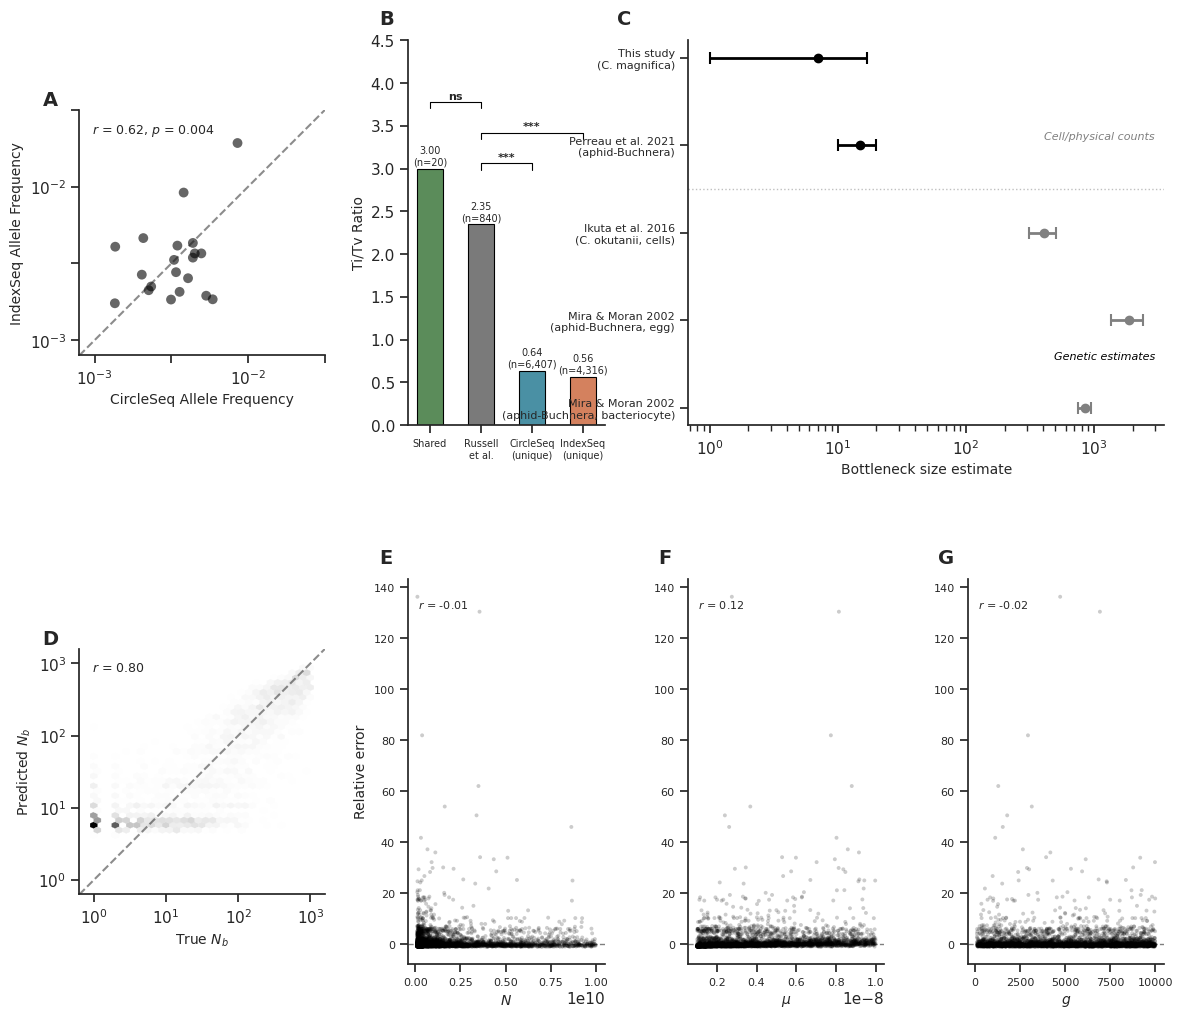

In [ ]:
fig2 = make_figure2(
    shared, circles, duplex, russell, test_df, emp_mean=7, emp_lower=1, emp_upper=17
)

In [ ]:
def plot_nuisance_heatmap(test_df, figsize=(3, 2.5)):
    """Correlation between nuisance params and predicted Nb."""

    sns.set_theme(style="ticks")

    df = test_df.copy()
    df["predicted_Nb"] = df["y_pred"]

    rows = {"N": "$N$", "u_per_site": "$\\mu$", "Gs": "$g$"}
    target = "predicted_Nb"

    # just compute correlations of each param with predicted Nb
    corr_values = {rows[col]: df[col].corr(df[target]) for col in rows}

    # make a small matrix: params x predicted Nb
    corr_matrix = pd.DataFrame(corr_values, index=["Predicted $N_b$"]).T

    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".2f",
        cmap="RdBu_r",
        center=0,
        vmin=-1,
        vmax=1,
        ax=ax,
        linewidths=0.5,
        linecolor="white",
        annot_kws={"fontsize": 11},
        cbar_kws={"shrink": 0.8, "label": "$r$"},
    )

    ax.tick_params(labelsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    fig.tight_layout()
    return fig

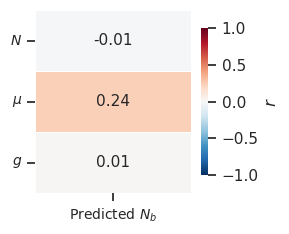

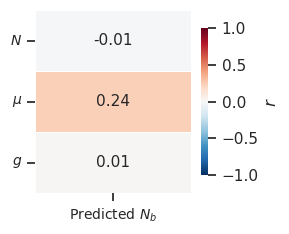

In [132]:
plot_nuisance_heatmap(test_df)

In [ ]:
def plot_nuisance_pairplot(test_df):
    """Pairplot showing only nuisance params don't predict Nb."""

    sns.set_theme(style="ticks")

    df = test_df.copy()
    df = df.rename(
        columns={
            "y_true": "$N_b$ (true)",
            "y_pred": "$N_b$ (predicted)",
            "N": "$N$",
            "u_per_site": "$\\mu$",
            "Gs": "$g$",
        }
    )

    cols = ["$N_b$ (true)", "$N_b$ (predicted)", "$N$", "$\\mu$", "$g$"]

    g = sns.pairplot(
        df[cols],
        corner=True,
        height=1.5,
        plot_kws=dict(alpha=0.15, s=5, color="black", edgecolors="none"),
        diag_kws=dict(color="lightgray", edgecolor="black", linewidth=0.5),
    )

    g.fig.tight_layout()
    return g.figure

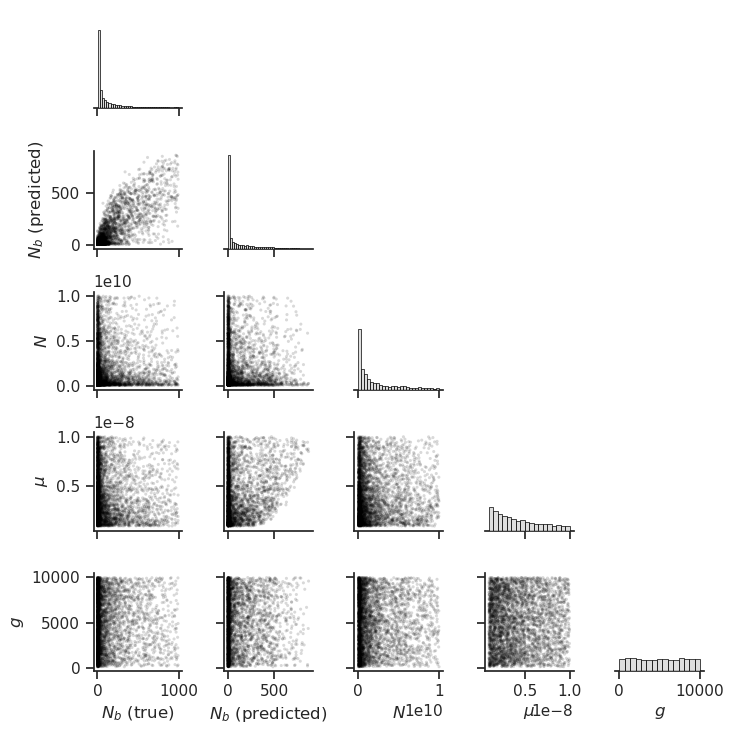

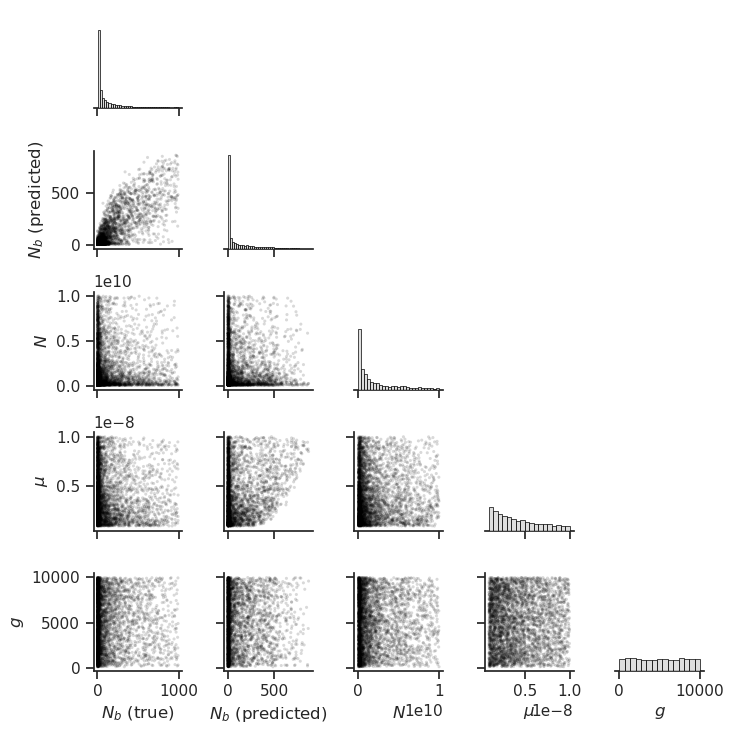

In [134]:
plot_nuisance_pairplot(test_df)